In [1]:
import numpy as np
import pycuda.driver as cuda
from gpuocean.utils import Common

gpu_ctx = Common.CUDAContext()

In [2]:
Nx = 100 # size with ghost cells 
Ny = 100 # size with ghost cells

nx = Nx - 4 # size without ghost cells
ny = Ny - 4 # size without ghost cells

In [3]:
defines={'block_width': 12, 'block_height': 32,
        'KPSIMULATOR_DESING_EPS': "{:.12f}f".format(0.1),
        'KPSIMULATOR_FLUX_SLOPE_EPS': "{:.12f}f".format(0.1),
        'KPSIMULATOR_DEPTH_CUTOFF': "{:.12f}f".format(1.0e-5),
        'THETA': "{:.12f}f".format(1.3),
        'RK_ORDER': int(2),
        'NX': int(nx),
        'NY': int(ny),
        'DX': "{:.12f}f".format(100),
        'DY': "{:.12f}f".format(100),
        'GRAV': "{:.12f}f".format(10.0),
        'FRIC': "{:.12f}f".format(0.0),
        'RHO_O': "{:.12f}f".format(1025.0)
        }

In [4]:
kernel = gpu_ctx.get_kernel("CDKLM16_kernel.cu", 
                defines=defines, 
                compile_args={                          # default, fast_math, optimal
                    'options' : ["--ftz=true",          # false,   true,      true
                                 "--prec-div=false",    # true,    false,     false,
                                 "--prec-sqrt=false",   # true,    false,     false
                                 "--fmad=false"]        # true,    true,      false
                })

In [5]:
gpu_stream = cuda.Stream()

In [6]:
field = np.repeat(np.arange(Nx)[np.newaxis], Ny, axis=0).astype(np.float32)

In [7]:
## Set texture
GPUtexref = kernel.get_texref("angle_tex")

gpu_stream.synchronize()
gpu_ctx.synchronize()

GPUtexref.set_array(cuda.np_to_array(field, order="C"))
GPUtexref.set_filter_mode(cuda.filter_mode.LINEAR) #bilinear interpolation
GPUtexref.set_address_mode(0, cuda.address_mode.CLAMP) #no indexing outside domain
GPUtexref.set_address_mode(1, cuda.address_mode.CLAMP)
GPUtexref.set_flags(cuda.TRSF_NORMALIZED_COORDINATES) #Use [0, 1] indexing

gpu_ctx.synchronize()

In [8]:
## Sample texture
local_size = (defines["block_width"], defines["block_height"], 1) 
global_size = (int(np.ceil(Nx / float(local_size[0]))), int(np.ceil(Ny / float(local_size[1]))) ) 
# ATTENTION: Ghost cells have to be included in the calculation of global_size


texref = Common.CUDAArray2D(gpu_stream, Nx, Ny, 0, 0, np.zeros((Ny,Nx)))
get_tex = kernel.get_function("get_texture")
get_tex.prepare("Pi")
get_tex.prepared_async_call(global_size, local_size, gpu_stream, texref.data.gpudata, np.int32(0))

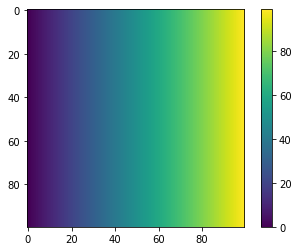

In [9]:
from matplotlib import pyplot as plt

plt.imshow(texref.data.get())
plt.colorbar()

In [10]:
texref.data.get()[2]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.], dtype=float32)